## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb, gray2rgb
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras.backend as K

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data

In [2]:
TRAIN_DIR = "../input/train/"
TARGET_SIZE = (224,224)
BATCH_SIZE = 32  # You can adjust this based on your GPU memory

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   # shear_range=0.2, zoom_range=0.2,
                                   # rotation_range=20, horizontal_flip=True
                                  )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=TARGET_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None)

Found 7129 images belonging to 1 classes.


## VGG16 

Defining VGG16 as an Encoder for our autoencoder architecture. Using VGG16 as a feature extractor.

In [3]:
# Defining the model
base_model = VGG16(include_top=False, weights='imagenet', 
                   input_shape=(224, 224, 3))

base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# Convert RGB images to LAB format and separate L and AB channels
def preprocess_lab(image_batch):
    lab_batch = rgb2lab(image_batch)
    X_batch = lab_batch[:, :, :, 0]  # L channel
    Y_batch = lab_batch[:, :, :, 1:] / 128  # AB channels between -1 and 1
    X_batch = X_batch.reshape(X_batch.shape + (1,))  # Add channel dimension for grayscale
    return X_batch, Y_batch

# Process the data in batches and extract VGG features
def extract_vgg_features(generator, model):
    vgg_features = []
    Y_targets = []  # Collect the target data for each batch
    for batch in generator:
        X_batch, Y_batch = preprocess_lab(batch)
        vgg_batch = model.predict(batch, verbose=0)  # Use the original 3-channel image for VGG
        vgg_features.append(vgg_batch)
        Y_targets.append(Y_batch)
        if len(vgg_features) * BATCH_SIZE >= len(generator.filenames):
            break
    return np.concatenate(vgg_features, axis=0), np.concatenate(Y_targets, axis=0)

In [5]:
%%time

# Extract VGG features and target data from the training data
vgg_features, Y = extract_vgg_features(train_generator, base_model)
vgg_features.shape, Y.shape

CPU times: total: 1min 37s
Wall time: 1min 55s


((7129, 7, 7, 512), (7129, 224, 224, 2))

In [6]:
K.clear_session()

## Decoder

Defining our own decoder model into which we'll pass the features extracted from VGG16.

To our decoder model, we'll pass the features learned by the vgg16 architecture as `X`, and the colored images as `y`.

In [7]:
# Define the deencoder model
model = models.Sequential(name='decoder_model')

# input_shape=(7,7,512) --> This is the o/p shape of encoder i.e. VGG16 model
# model.add(layers.Conv2D(512, (3,3), 
#                         activation='relu', 
#                         padding='same', 
#                         input_shape=(7,7,512)))

model.add(layers.InputLayer(input_shape=(7,7,512)))

model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
# model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(4, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001), 
              loss='mse', 
              metrics=['accuracy'])

model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)      

In [8]:
# from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# # Apply Early Stopping callback
# # early_stopping = EarlyStopping(monitor='loss', 
# #                                patience=50,
# #                                restore_best_weights=True)

# tensorboard = TensorBoard(log_dir="../output/callbacks")

In [9]:
%%time

# Train the decoder
history = model.fit(vgg_features, Y,
                    verbose=1,
                    epochs=50, 
                    batch_size=BATCH_SIZE,
                    # callbacks=[tensorboard], #early_stopping
                    workers=10)

Epoch 1/50
223/223 [==============================] - 5s 16ms/step - loss: 0.0118 - accuracy: 0.6216
Epoch 2/50
223/223 [==============================] - 3s 15ms/step - loss: 0.0104 - accuracy: 0.6623
Epoch 3/50
223/223 [==============================] - 3s 15ms/step - loss: 0.0098 - accuracy: 0.6784
Epoch 4/50
223/223 [==============================] - 3s 14ms/step - loss: 0.0094 - accuracy: 0.6864
Epoch 5/50
223/223 [==============================] - 3s 15ms/step - loss: 0.0090 - accuracy: 0.6934
Epoch 6/50
223/223 [==============================] - 3s 15ms/step - loss: 0.0087 - accuracy: 0.6974
Epoch 7/50
223/223 [==============================] - 3s 15ms/step - loss: 0.0083 - accuracy: 0.7018
Epoch 8/50
223/223 [==============================] - 3s 15ms/step - loss: 0.0081 - accuracy: 0.7052
Epoch 9/50
223/223 [==============================] - 3s 15ms/step - loss: 0.0079 - accuracy: 0.7088
Epoch 10/50
223/223 [==============================] - 3s 14ms/step - loss: 0.0076 - accura

In [10]:
K.clear_session()

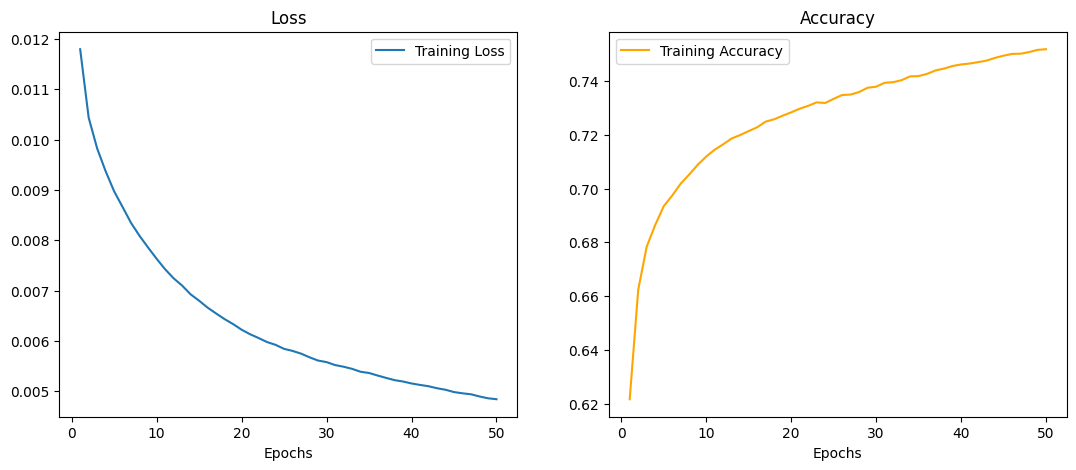

In [11]:
loss = history.history['loss']
accuracy = history.history['accuracy']

epochs = range(1, len(loss)+1)

# Plot loss
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(epochs, loss, label="Training Loss")
plt.xlabel("Epochs")
plt.legend()


# Plot accuracy
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(epochs, accuracy, label="Training Accuracy", color='orange')
plt.xlabel("Epochs")
plt.legend();

In [12]:
test = img_to_array(load_img('../input/test/t3.jpg'))

test = resize(test, (224,224),)
test*= 1.0/255

lab = rgb2lab(test)

l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))

vgg_pred = base_model.predict(L)
ab = model.predict(vgg_pred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

colored_img = lab2rgb(cur)

1/1 [==============================] - 0s 197ms/step


C:\Users\Amit Vikram Raj\AppData\Local\Temp\ipykernel_4056\2017774601.py:19: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 214 negative Z values that have been clipped to zero
  colored_img = lab2rgb(cur)


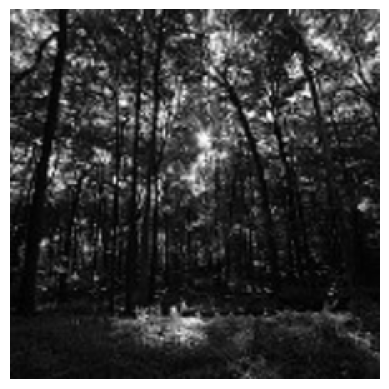

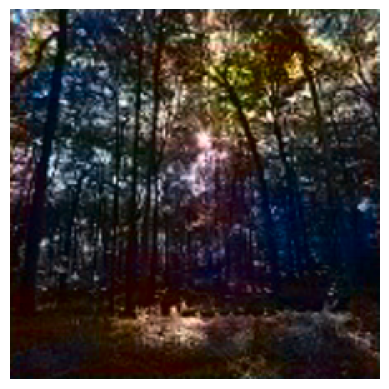

In [13]:
plt.figure()
plt.imshow(test)
plt.axis("off");

plt.figure()
plt.imshow(colored_img)
plt.axis("off");